# Principal Component Analysis with Cancer Data

In [9]:
#Import all the necessary modules
#Import all the necessary modules
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools
from IPython.display import Image  
from os import system
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
np.random.seed(1234)

# Q1. Load the Data file into Python DataFrame and view top 10 rows

In [10]:
colnames = ['ID','Clump-Thickness','Cell-Size','Cell-Shape','Marginal Adhesion','Single-Epth Cell Size','Bare_Nuclei', 'Normal_Nuclei','Bland Chromatin', 'Mitoses','Class']
bc_df=pd.read_csv("breast-cancer-wisconsin.data.txt", names =colnames)

In [11]:
bc_df.head(10)

,ID,Clump-Thickness,Cell-Size,Cell-Shape,Marginal Adhesion,Single-Epth Cell Size,Bare_Nuclei,Normal_Nuclei,Bland Chromatin,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [12]:
  # Id columns is to identify rows hence can be skipped in analysis
  # All columns have numerical values
  # Class would be the target variable. Should be removed when PCA is done

# Q2 Print the datatypes of each column and the shape of the dataset. Perform descriptive analysis 

In [13]:
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID                       699 non-null int64
Clump-Thickness          699 non-null int64
Cell-Size                699 non-null int64
Cell-Shape               699 non-null int64
Marginal Adhesion        699 non-null int64
Single-Epth Cell Size    699 non-null int64
Bare_Nuclei              699 non-null object
Normal_Nuclei            699 non-null int64
Bland Chromatin          699 non-null int64
Mitoses                  699 non-null int64
Class                    699 non-null int64
dtypes: int64(10), object(1)
memory usage: 57.4+ KB


In [14]:
bc_df.shape

(699, 11)

In [15]:
def plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True):
    cm = metrics.confusion_matrix(Y_test, Y_predict)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    print(metrics.classification_report(Y_test, Y_predict))
    model_performance = [metrics.accuracy_score(Y_test, Y_predict),metrics.recall_score(Y_test, Y_predict),
                         metrics.precision_score(Y_test, Y_predict),metrics.f1_score(Y_test, Y_predict) ]
    accuracy_report = pd.DataFrame(model_performance, columns=['Model_Performance'], 
                                   index=['Accuracy','Recall','Precision','f1_Score'])
    return accuracy_report
    
def EDA_Corr(df):
    corr = df.corr()
    index = corr.columns
    Output = []
    for i in range(0,len(index)):
        i = index[i]
        Pos = corr.index[(corr[i] >= 0.5)].tolist()
        No = corr.index[(corr[i] < 0.5) & (corr[i] > -0.6)].tolist()
        Neg = corr.index[(corr[i] <= -0.5)].tolist()
        leng_u = len(No)
        leng_pos = len(Pos)
        leng_neg = len(Neg)
        Out = [i, leng_u, leng_pos, leng_neg, Pos, Neg, No]
        Output.append(Out)
    fig, ax = plt.subplots(figsize=(20,10))  
    sns.heatmap(corr,annot=True,vmin=-1,vmax=1,cmap='Blues', linewidths=0, ax = ax)
    Output1 = pd.DataFrame(Output, columns= ['Feature','Uniqueness','Positive rel', 'inverse rel', 'Pos', 'Neg', 'No'])
    return Output1

def EDA(df):
    EDA = pd.DataFrame((df.describe()).T)
    EDA["Kurtosis"] = df.kurtosis()
    EDA["Skewness"] = df.skew()
    EDA["Range"] = EDA['max'] -  EDA['min']
    EDA["IQR"] = EDA['75%'] -  EDA['25%']
    return EDA

In [17]:
bc1_df=bc_df.drop('ID',axis=1)

In [18]:
EDA(bc1_df)

,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skewness,Range,IQR
Clump-Thickness,699.0,4.417740,2.815741,1.0,2.0,4.0,6.0,10.0,-0.623715,0.592859,9.0,4.0
Cell-Size,699.0,3.134478,3.051459,1.0,1.0,1.0,5.0,10.0,0.098803,1.233137,9.0,4.0
Cell-Shape,699.0,3.207439,2.971913,1.0,1.0,1.0,5.0,10.0,0.007011,1.161859,9.0,4.0
Marginal Adhesion,699.0,2.806867,2.855379,1.0,1.0,1.0,4.0,10.0,0.987947,1.524468,9.0,3.0
Single-Epth Cell Size,699.0,3.216023,2.214300,1.0,2.0,2.0,4.0,10.0,2.169066,1.712172,9.0,2.0
Normal_Nuclei,699.0,3.437768,2.438364,1.0,2.0,3.0,5.0,10.0,0.184621,1.099969,9.0,3.0
Bland Chromatin,699.0,2.866953,3.053634,1.0,1.0,1.0,4.0,10.0,0.474269,1.422261,9.0,3.0
Mitoses,699.0,1.589413,1.715078,1.0,1.0,1.0,1.0,10.0,12.657878,3.560658,9.0,0.0
Class,699.0,2.689557,0.951273,2.0,2.0,2.0,4.0,4.0,-1.576064,0.654564,2.0,2.0


# Q3 Check for missing value check, incorrect data, duplicate data and perform imputation with mean, median, mode as necessary.


In [31]:
# We can see that Bare_Nuclei has some missing data
# We could see "?" values in column, this should be removed from data set
bc1_df.isna()
# Check for missing value in any other column

,Clump-Thickness,Cell-Size,Cell-Shape,Marginal Adhesion,Single-Epth Cell Size,Bare_Nuclei,Normal_Nuclei,Bland Chromatin,Mitoses,Class
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [33]:
# No missing values found. So let us try to remove ? from bare nuclei column
bc1_df[bc1_df['Bare_Nuclei']=='?'].shape[0]
# Get count of rows having ?


16

In [34]:
bc1_df['Bare_Nuclei']=bc1_df['Bare_Nuclei'].replace('?',0)
bc1_df['Bare_Nuclei']=pd.to_numeric(bc1_df['Bare_Nuclei'])

In [35]:
bc1_df['Bare_Nuclei']=bc1_df['Bare_Nuclei'].replace(0,bc1_df['Bare_Nuclei'].median())

In [36]:
# 16 values are corrupted. We can either delete them as it forms roughly 2% of data.
# Here we would like to impute it with suitable values

# Q4. Perform bi variate analysis including correlation, pairplots and state the inferences. 


In [40]:
bc_cols = [col_name for col_name in bc_df.drop(['ID'], axis=1).columns]

In [41]:
len(bc_cols)

10

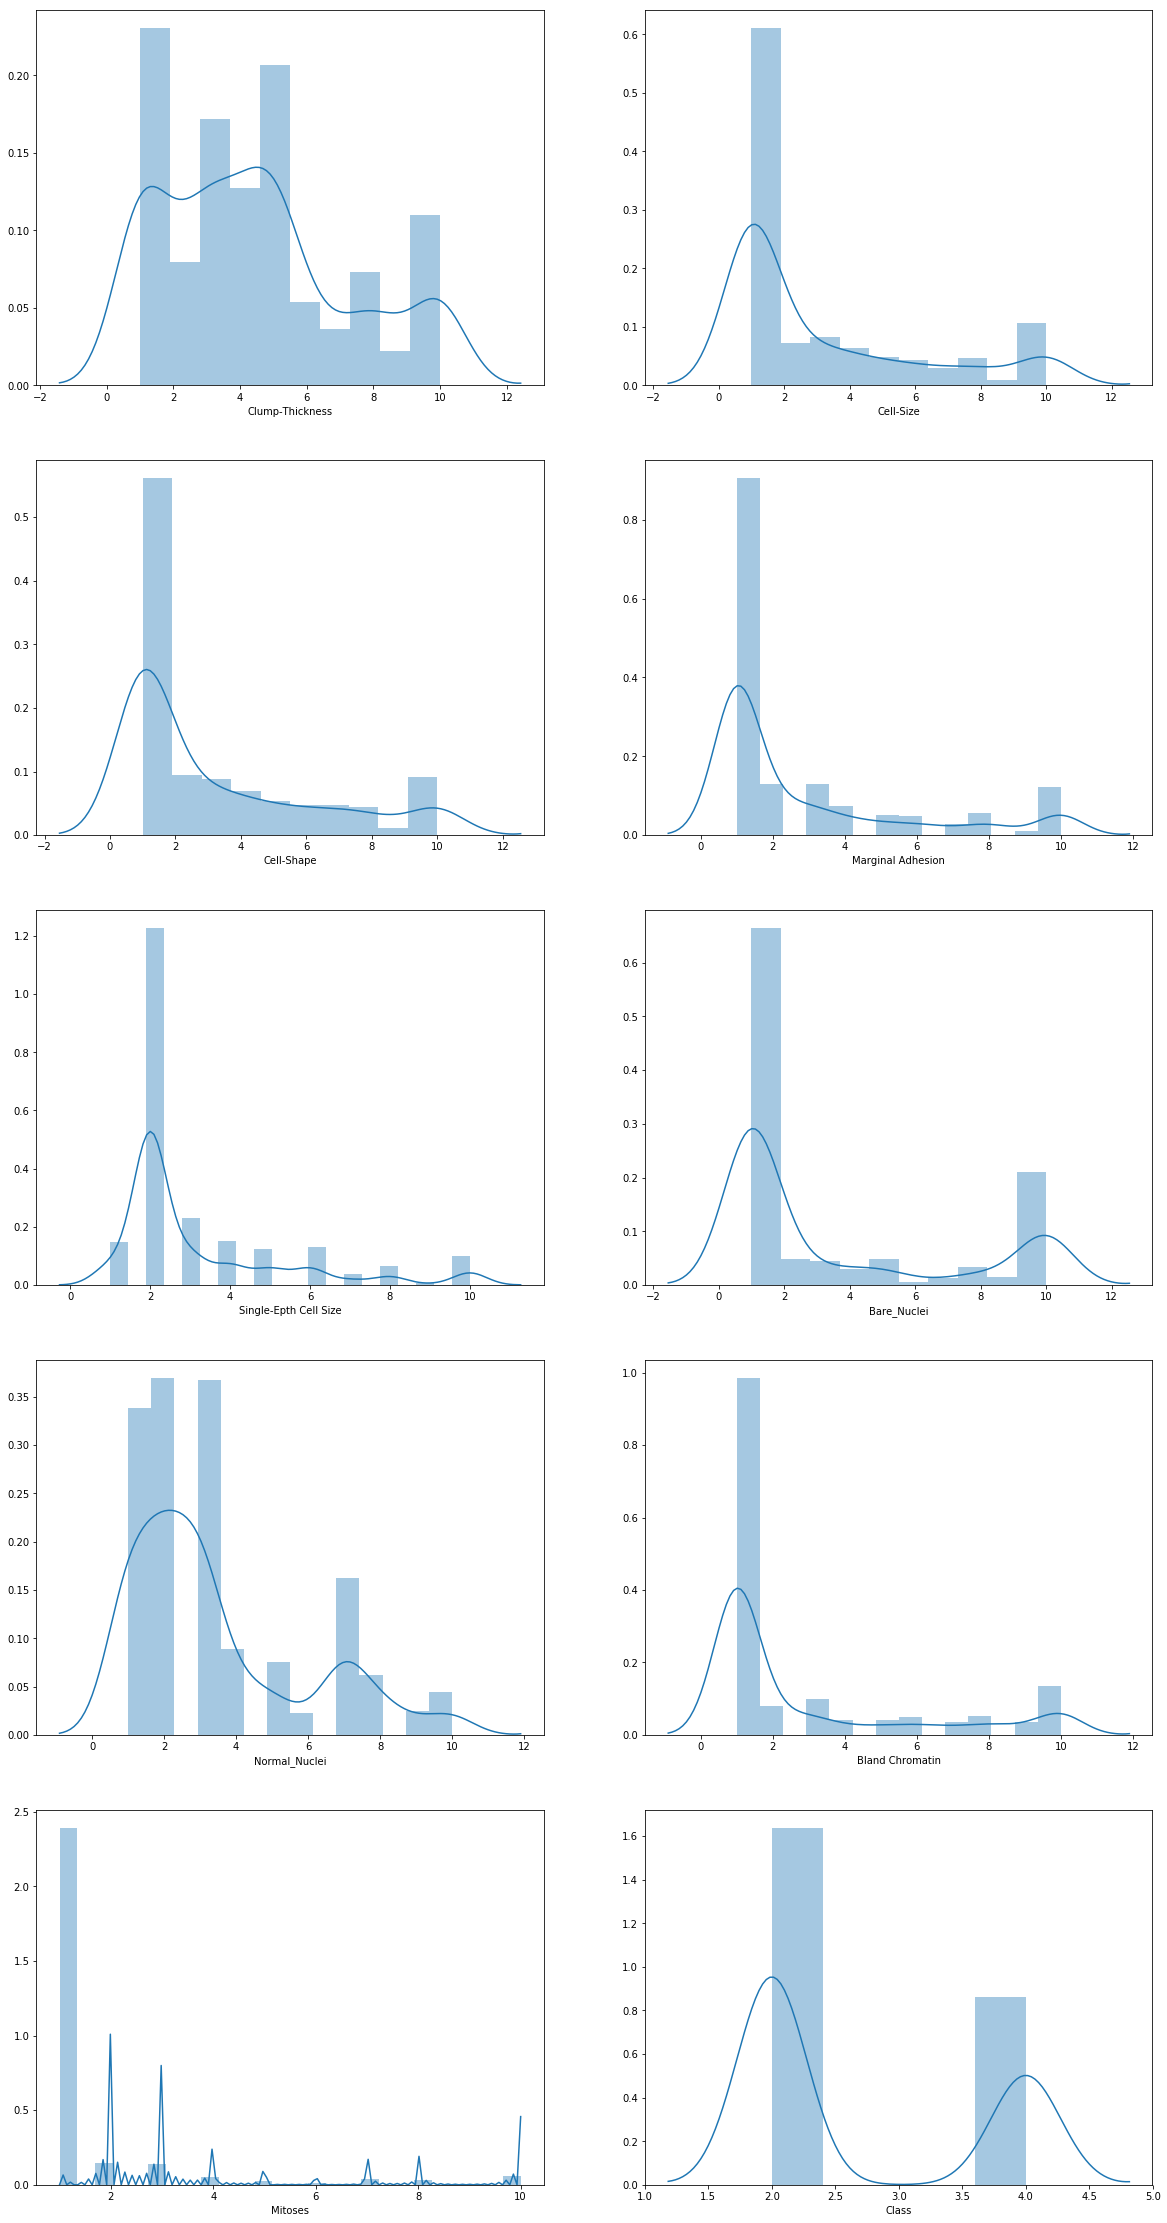

In [42]:
f,axs= plt.subplots(nrows = 5,ncols = 2,figsize=(20,40))
for i in range(0, len(bc_cols)):
    rows = i // 2
    cols = i % 2
    ax = axs[(rows, cols)]
    plot=sns.distplot(bc_df[bc_cols[i]],ax=ax); 

In [37]:
# Check for correlation of variable

In [43]:
bc1_df.corr()

,Clump-Thickness,Cell-Size,Cell-Shape,Marginal Adhesion,Single-Epth Cell Size,Bare_Nuclei,Normal_Nuclei,Bland Chromatin,Mitoses,Class
Clump-Thickness,1.000000,0.644913,0.654589,0.486356,0.521816,0.590008,0.558428,0.535835,0.350034,0.716001
Cell-Size,0.644913,1.000000,0.906882,0.705582,0.751799,0.686673,0.755721,0.722865,0.458693,0.817904
Cell-Shape,0.654589,0.906882,1.000000,0.683079,0.719668,0.707474,0.735948,0.719446,0.438911,0.818934
Marginal Adhesion,0.486356,0.705582,0.683079,1.000000,0.599599,0.666971,0.666715,0.603352,0.417633,0.696800
Single-Epth Cell Size,0.521816,0.751799,0.719668,0.599599,1.000000,0.583701,0.616102,0.628881,0.479101,0.682785
Bare_Nuclei,0.590008,0.686673,0.707474,0.666971,0.583701,1.000000,0.674215,0.574778,0.342397,0.818968
Normal_Nuclei,0.558428,0.755721,0.735948,0.666715,0.616102,0.674215,1.000000,0.665878,0.344169,0.756616
Bland Chromatin,0.535835,0.722865,0.719446,0.603352,0.628881,0.574778,0.665878,1.000000,0.428336,0.712244
Mitoses,0.350034,0.458693,0.438911,0.417633,0.479101,0.342397,0.344169,0.428336,1.000000,0.423170
Class,0.716001,0.817904,0.818934,0.696800,0.682785,0.818968,0.756616,0.712244,0.423170,1.000000


,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
0,Clump-Thickness,2,8,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Singl...",[],"[Marginal Adhesion, Mitoses]"
1,Cell-Size,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]
2,Cell-Shape,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]
3,Marginal Adhesion,2,8,0,"[Cell-Size, Cell-Shape, Marginal Adhesion, Sin...",[],"[Clump-Thickness, Mitoses]"
4,Single-Epth Cell Size,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]
5,Bare_Nuclei,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]
6,Normal_Nuclei,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]
7,Bland Chromatin,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]
8,Mitoses,9,1,0,[Mitoses],[],"[Clump-Thickness, Cell-Size, Cell-Shape, Margi..."
9,Class,1,9,0,"[Clump-Thickness, Cell-Size, Cell-Shape, Margi...",[],[Mitoses]


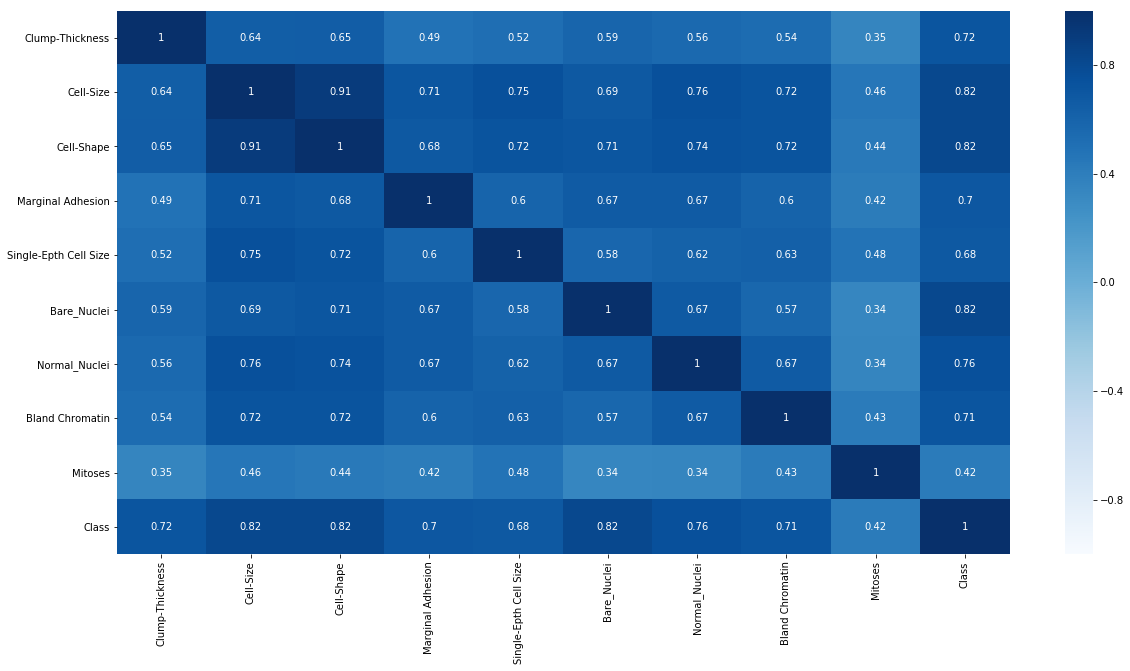

In [38]:
EDA_Corr(bc1_df)

In [0]:
# Cell size shows high significance with cell shape,marginal adhesion, single epithelial cell size,bare nuclei, normal nucleoli 
# and bland chromatin
# Target variable shows high correlation with most of these variables

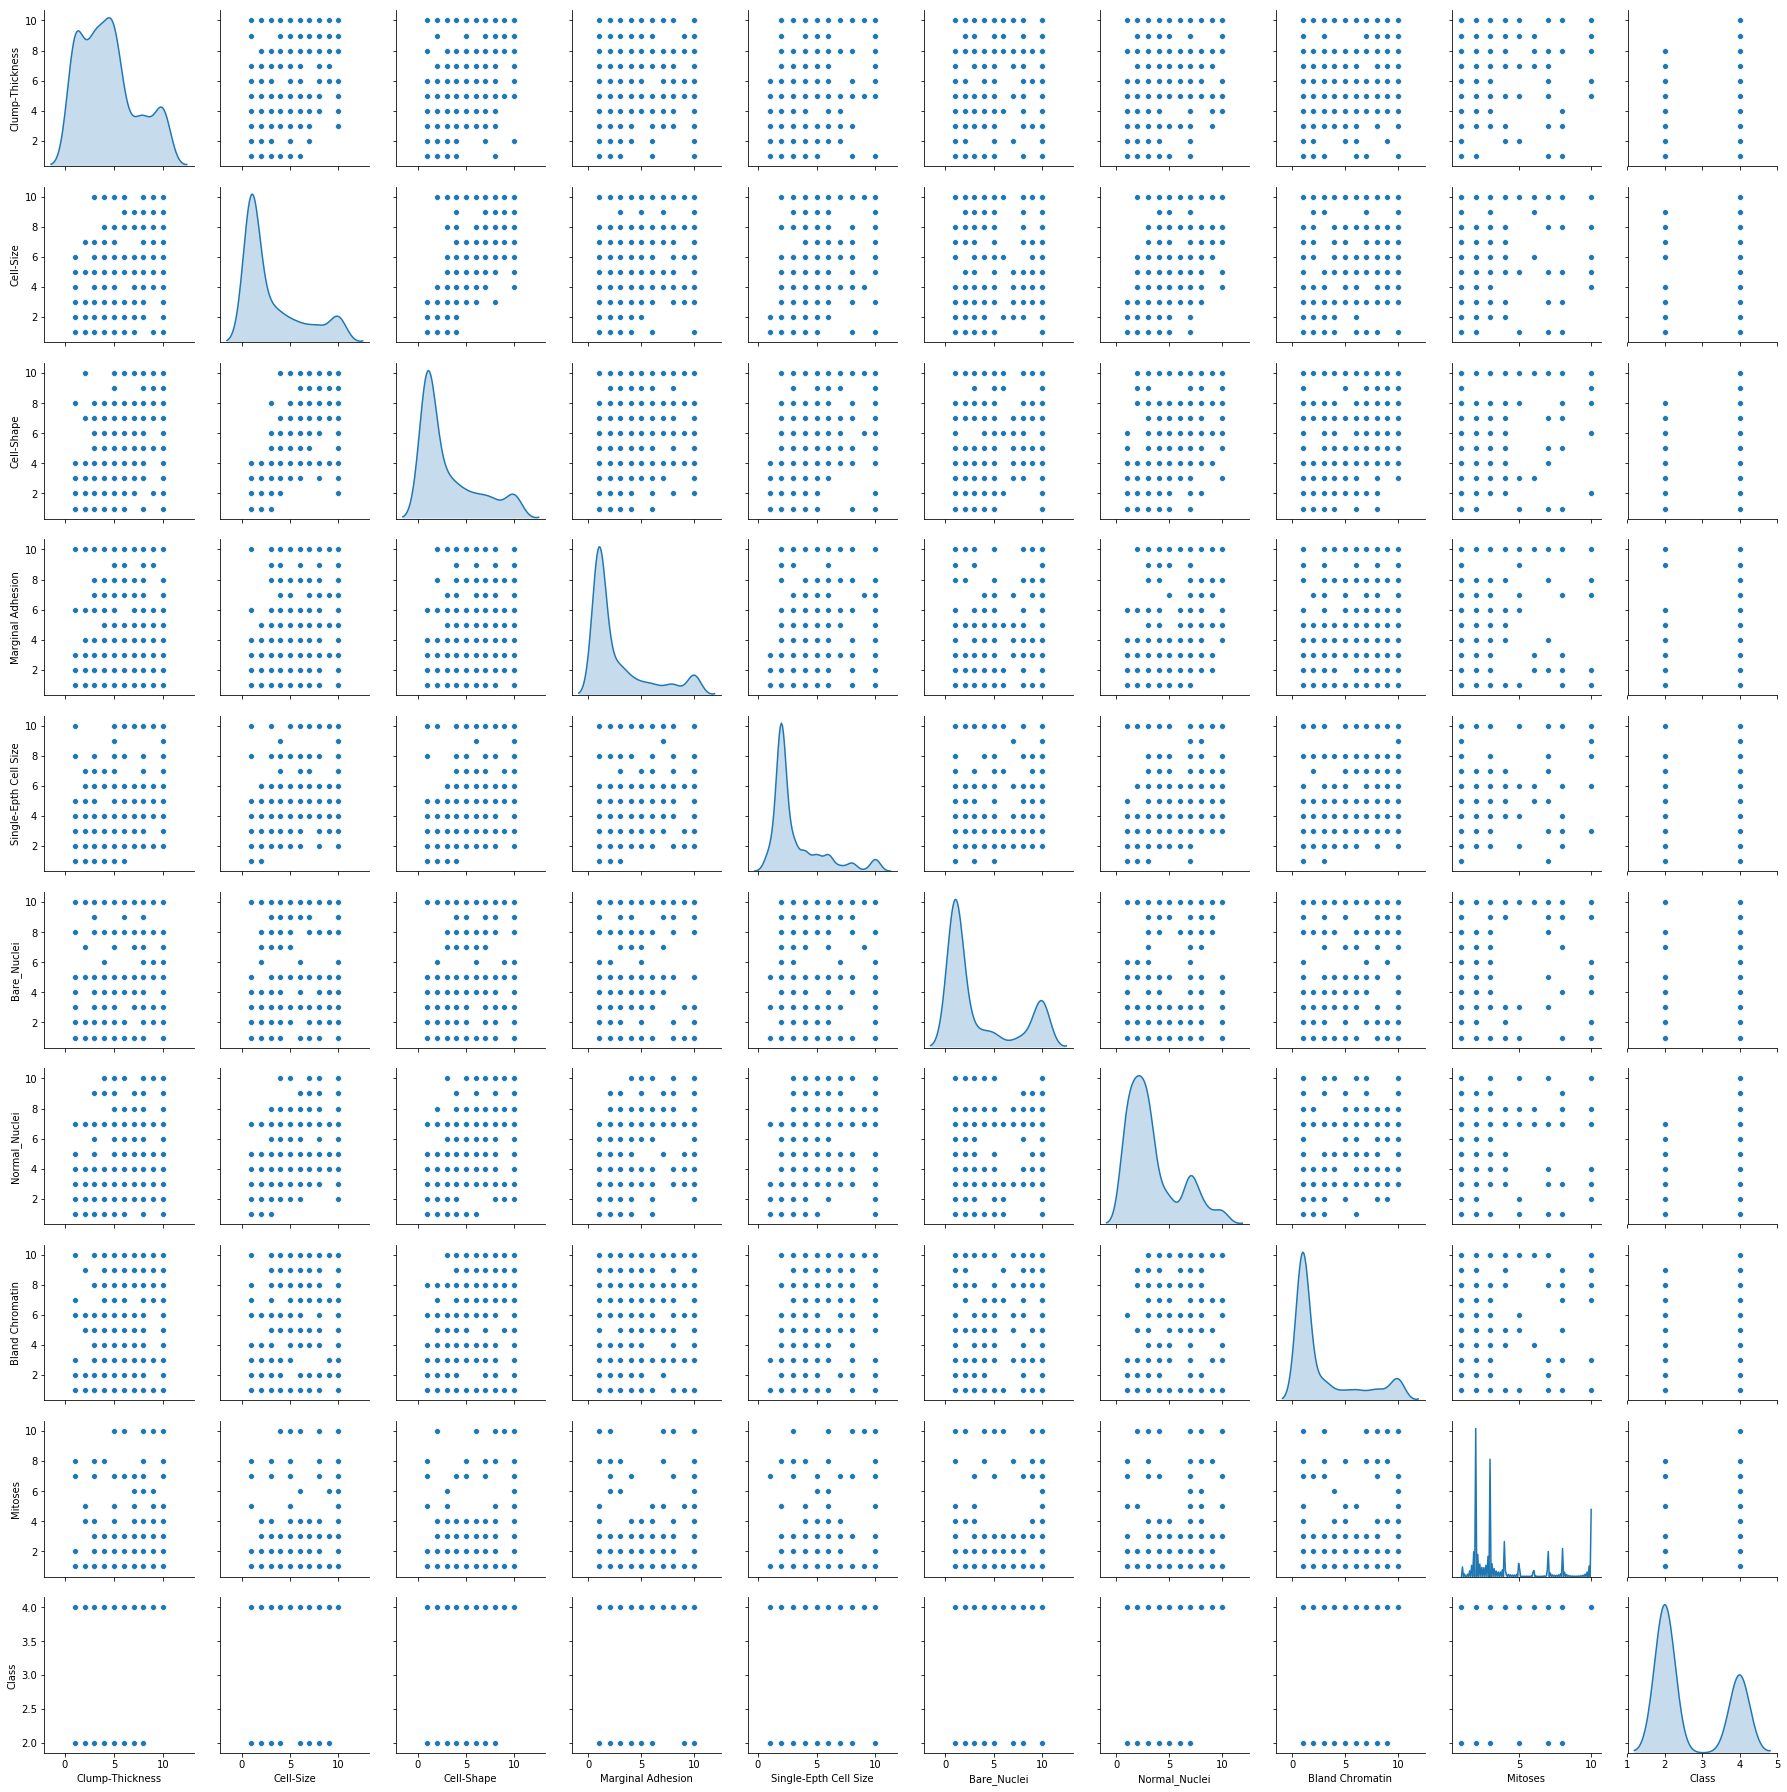

In [44]:
#Let us check for pair plots
sns.pairplot(bc1_df,diag_kind='kde')

In [0]:
# Relationship between variables shows come correlation. 
# Distribution of variables shows most of the values are concentrated on lower side, though range remains same for all that is 
# Between 1 to 10

# Q5 Remove any unwanted columns or outliers, standardize variables in pre-processing step

In [0]:
# We could see most of the outliers are now removed.

In [50]:
bc1_df['Mitoses'].value_counts()

1     579
2      35
3      33
10     14
4      12
7       9
8       8
5       6
6       3
Name: Mitoses, dtype: int64

In [45]:
bc1_df.drop('Class',axis=1)

,Clump-Thickness,Cell-Size,Cell-Shape,Marginal Adhesion,Single-Epth Cell Size,Bare_Nuclei,Normal_Nuclei,Bland Chromatin,Mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
5,8,10,10,8,7,10,9,7,1
6,1,1,1,1,2,10,3,1,1
7,2,1,2,1,2,1,3,1,1
8,2,1,1,1,2,1,1,1,5
9,4,2,1,1,2,1,2,1,1


In [46]:
X=bc1_df

In [47]:
y=bc_df['Class']

# Q6 Create a covariance matrix for identifying Principal components

In [53]:
# PCA
# Step 1 - Create covariance matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA
from scipy.stats import zscore

sc = StandardScaler()
X_std =  sc.fit_transform(X)   
cov_matrix = np.cov(X_std.T)
print('Covariance Matrix \n%s', cov_matrix)


Covariance Matrix 
%s [[1.00143266 0.64583645 0.65552689 0.48705303 0.52256381 0.5908535
  0.5592282  0.53660222 0.35053534 0.71702715]
 [0.64583645 1.00143266 0.90818117 0.70659267 0.75287621 0.68765657
  0.75680368 0.72390044 0.4593503  0.81907552]
 [0.65552689 0.90818117 1.00143266 0.68405782 0.72069948 0.70848734
  0.73700282 0.72047704 0.43953974 0.820107  ]
 [0.48705303 0.70659267 0.68405782 1.00143266 0.60045809 0.66792658
  0.66767051 0.60421681 0.41823111 0.69779849]
 [0.52256381 0.75287621 0.72069948 0.60045809 1.00143266 0.5845377
  0.61698451 0.62978166 0.47978787 0.68376273]
 [0.5908535  0.68765657 0.70848734 0.66792658 0.5845377  1.00143266
  0.67518063 0.5756016  0.34288766 0.82014124]
 [0.5592282  0.75680368 0.73700282 0.66767051 0.61698451 0.67518063
  1.00143266 0.66683179 0.34466258 0.75770012]
 [0.53660222 0.72390044 0.72047704 0.60421681 0.62978166 0.5756016
  0.66683179 1.00143266 0.42894941 0.71326403]
 [0.35053534 0.4593503  0.43953974 0.41823111 0.47978787 0.34

# Q7 Identify eigen values and eigen vector

In [ ]:
# Step 2- Get eigen values and eigen vector

In [54]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[-2.86482867e-01 -1.53780587e-01  8.19948678e-01 -1.93537912e-02
  -1.65922965e-01 -4.61058785e-02  5.69495446e-02 -2.43129182e-01
   3.52570674e-01 -7.26042747e-02]
 [-3.55778408e-01 -1.61465406e-02 -6.50741903e-02 -7.40430469e-01
  -4.01924327e-04 -2.22911943e-01 -1.39409782e-01  4.50063303e-01
   1.51365691e-01  1.61541178e-01]
 [-3.52927539e-01 -5.49545490e-02 -1.02133723e-02  6.48405184e-01
  -1.98081731e-01 -2.00817488e-01 -1.06583143e-01  5.84436739e-01
   7.36978525e-02  1.18181541e-01]
 [-3.09682474e-01 -8.63368905e-03 -4.09371880e-01  4.63478603e-02
   1.93963223e-02  4.69881739e-01  2.09498895e-02 -9.24327656e-02
   6.38821338e-01 -3.09916575e-01]
 [-3.11685681e-01  1.98540206e-01 -1.52492504e-01  6.56015232e-02
  -1.44016509e-02 -3.67092365e-01 -6.77581126e-01 -4.55359042e-01
  -9.99685292e-02 -1.56366046e-01]
 [-3.17155278e-01 -2.47988578e-01  3.94605610e-02 -1.12128053e-01
  -4.07592475e-01  5.32423724e-01 -1.28628247e-01  3.73420635e-02
  -5.73504501e-

In [55]:
# Make a set of (eigenvalue, eigenvector) pairs
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()

eig_pairs.reverse()
print(eig_pairs)

# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(6.724729398431275, array([-0.28648287, -0.35577841, -0.35292754, -0.30968247, -0.31168568,
       -0.31715528, -0.32377844, -0.31292865, -0.21022101, -0.35525072])), (0.7931217144819475, array([-0.15378059, -0.01614654, -0.05495455, -0.00863369,  0.19854021,
       -0.24798858, -0.19401019,  0.05753435,  0.89823671, -0.15588581])), (0.5482268307358845, array([ 0.81994868, -0.06507419, -0.01021337, -0.40937188, -0.1524925 ,
        0.03946056, -0.23106396, -0.17684196,  0.16469144,  0.13842638])), (0.4733608626033487, array([-0.04610588, -0.22291194, -0.20081749,  0.46988174, -0.36709236,
        0.53242372, -0.00142836, -0.43182875,  0.257723  ,  0.12624152])), (0.38113751791113853, array([ 0.05694954, -0.13940978, -0.10658314,  0.02094989, -0.67758113,
       -0.12862825,  0.25097715,  0.6395611 ,  0.13196946,  0.02043334])), (0.31568450377597423, array([ 0.35257067,  0.15136569,  0.07369785,  0.63882134, -0.09996853,
       -0.5735045 , -0.00895897, -0.19858877, -0.09147643, -0.229

# Q8 Find variance and cumulative variance by each eigen vector

In [56]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 10 entries as there are 10 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 8 entries with 8 th entry 
# cumulative reaching almost 100%

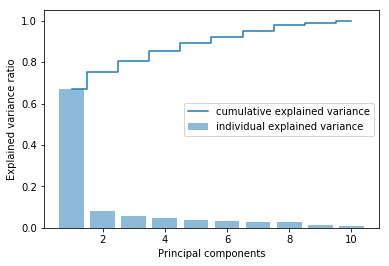

In [60]:
plt.bar(range(1,11), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,11),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

# Q9 Use PCA command from sklearn and find Principal Components. Transform data to components formed

In [62]:
from sklearn.decomposition import PCA

In [61]:
X_centered = X - X.mean(axis=0)

In [63]:
pca = PCA(n_components=4) # Since 4 components explain more than 80% of variance
pca.fit(X_centered)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [64]:
X_pca = pca.transform(X_centered)

In [65]:
X_pca.shape

(699, 4)

# Q10 Find correlation between components and features

In [69]:
df= pd.DataFrame(pca.components_,columns=X.columns)

In [70]:
df

,Clump-Thickness,Cell-Size,Cell-Shape,Marginal Adhesion,Single-Epth Cell Size,Bare_Nuclei,Normal_Nuclei,Bland Chromatin,Mitoses,Class
0,0.296404,0.401162,0.389150,0.328767,0.247934,0.436874,0.289904,0.353715,0.122614,0.123148
1,-0.065958,0.228701,0.166285,-0.093464,0.186105,-0.782808,0.016922,0.480473,0.163150,-0.042162
2,-0.845841,-0.025034,-0.074299,0.486231,0.049085,0.092512,0.109133,0.129104,0.034684,-0.035181
3,0.069790,0.285142,0.198967,0.399097,0.199641,-0.303953,-0.046423,-0.744643,0.159446,-0.025345


In [71]:
df.corr()

,Clump-Thickness,Cell-Size,Cell-Shape,Marginal Adhesion,Single-Epth Cell Size,Bare_Nuclei,Normal_Nuclei,Bland Chromatin,Mitoses,Class
Clump-Thickness,1.000000,0.994401,0.967513,-0.331612,0.998595,0.007211,0.182150,-0.070806,0.819397,0.596059
Cell-Size,0.994401,1.000000,0.987509,-0.267766,0.994735,0.110267,0.278189,-0.041676,0.754294,0.676782
Cell-Shape,0.967513,0.987509,1.000000,-0.237412,0.974025,0.224479,0.424494,0.071752,0.657057,0.776518
Marginal Adhesion,-0.331612,-0.267766,-0.237412,1.000000,-0.358764,0.732007,0.218997,-0.526126,-0.626532,0.188207
Single-Epth Cell Size,0.998595,0.994735,0.974025,-0.358764,1.000000,0.012131,0.214630,-0.017895,0.810151,0.613762
Bare_Nuclei,0.007211,0.110267,0.224479,0.732007,0.012131,1.000000,0.820366,0.054209,-0.558390,0.756385
Normal_Nuclei,0.182150,0.278189,0.424494,0.218997,0.214630,0.820366,1.000000,0.573744,-0.367741,0.877553
Bland Chromatin,-0.070806,-0.041676,0.071752,-0.526126,-0.017895,0.054209,0.573744,1.000000,-0.189192,0.278980
Mitoses,0.819397,0.754294,0.657057,-0.626532,0.810151,-0.558390,-0.367741,-0.189192,1.000000,0.035673
Class,0.596059,0.676782,0.776518,0.188207,0.613762,0.756385,0.877553,0.278980,0.035673,1.000000


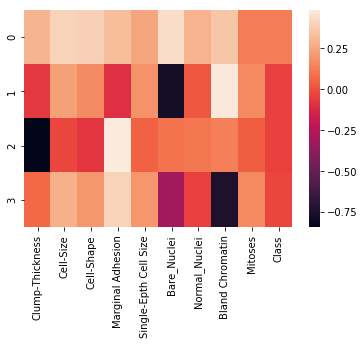

In [72]:
sns.heatmap(df)

# Content Based Recommendation System

# Q11 Read the Dataset `movies_metadata.csv`

# Q12 Create a new column with name 'description' combining `'overview' and 'tagline'` columns in the given dataset

# Q13  Lets drop the null values in `description` column

# Q14 Keep the first occurance and drop duplicates of each title in column `title`

# Q15   As we might have dropped a few rows with duplicate `title` in above step, just reset the index [make sure you are not adding any new column to the dataframe while doing reset index]

# Q16    Generate tf-idf matrix using the column `description`. Consider till 3-grams, with minimum document frequency as 0.

# Q17  Create cosine similarity matrix

# Q18  Write a function with name `recommend` which takes `title` as argument and returns a list of 10 recommended title names in the output based on the above cosine similarities

# Q19 Give the recommendations from above functions for movies `The Godfather` and `The Dark Knight Rises`

# Popularity Based Recommendation System

### About Dataset

Anonymous Ratings on jokes.

1. Ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" = "not rated").

2. One row per user

3. The first column gives the number of jokes rated by that user. The next 100 columns give the ratings for jokes 01 - 100.

# Q20 Read the dataset(jokes.csv)

Take care about the header in read_csv() as there are no column names given in the dataset. 

In [66]:
jokes_df=pd.read_csv("jokes.csv")

In [67]:
jokes_df.head(10)

,NumJokes,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,...,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
5,100,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45
6,47,99.00,99.00,99.00,99.00,8.59,-9.85,7.72,8.79,99.00,...,99.00,99.00,99.00,99.00,99.00,2.33,99.00,99.00,99.00,99.00
7,100,6.84,3.16,9.17,-6.21,-8.16,-1.70,9.27,1.41,-5.19,...,7.23,-1.12,-0.10,-5.68,-3.16,-3.35,2.14,-0.05,1.31,0.00
8,100,-3.79,-3.54,-9.42,-6.89,-8.74,-0.29,-5.29,-8.93,-7.86,...,4.37,-0.29,4.17,-0.29,-0.29,-0.29,-0.29,-0.29,-3.40,-4.95
9,72,3.01,5.15,5.15,3.01,6.41,5.15,8.93,2.52,3.01,...,99.00,4.47,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00


In [73]:
jokes_df.shape

(24983, 101)

# Q21 Consider `ratings` named dataframe with only first 200 rows and all columns from 1(first column is 0) of dataset

In [77]:
ratings=jokes_df.iloc[0:200,:]

# Q22 Change the column indices from 0 to 99

In [82]:
ratings=ratings.drop('NumJokes',axis=1)

In [83]:
ratings.columns=np.arange(0,100)

# Q23 In the dataset, the null ratings are given as 99.00, so replace all 99.00s with 0
Hint: You can use `ratings.replace(<the given value>, <new value you wanted to change with>)`

In [84]:
ratings=ratings.replace(99,0)

# Q24 Normalize the ratings using StandardScaler and save them in `ratings_diff` variable

In [85]:
StdScl=StandardScaler()
ratings_diff =  StdScl.fit_transform(ratings)

### Popularity based recommendation system

# Q25  Find the mean for each column  in `ratings_diff` i.e, for each joke
Consider all the mean ratings and find the jokes with highest mean value and display the top 10 joke IDs.

In [87]:
ratings_diff=pd.DataFrame(ratings_diff)

In [89]:
ratings_diff.mean().transpose()

0    -1.110223e-17
1    -9.658940e-17
2    -4.107825e-17
3     3.719247e-17
4    -8.881784e-18
5    -2.636780e-18
6    -1.665335e-18
7     2.331468e-17
8    -4.329870e-17
9    -2.553513e-17
10   -4.551914e-17
11   -8.604228e-17
12    6.661338e-17
13    5.467848e-17
14   -2.164935e-17
15   -1.065814e-16
16    1.637579e-17
17    2.331468e-17
18   -9.159340e-18
19    2.997602e-17
20    1.065814e-16
21    1.720846e-17
22   -2.775558e-17
23    4.329870e-17
24   -3.885781e-17
25   -1.498801e-17
26   -3.996803e-17
27   -9.436896e-18
28   -5.273559e-17
29    1.998401e-17
          ...     
70    7.632783e-19
71   -9.325873e-17
72   -4.024558e-17
73    7.743806e-17
74    1.290634e-17
75    3.885781e-17
76    3.747003e-18
77   -2.886580e-17
78   -9.853229e-18
79   -6.938894e-17
80    3.941292e-17
81    1.243450e-16
82    0.000000e+00
83    2.498002e-17
84   -2.045586e-16
85   -1.290634e-17
86   -8.465451e-17
87    5.107026e-17
88    2.997602e-17
89   -6.369905e-17
90   -4.385381e-17
91   -3.4972

In [93]:
ratings_diff.mean().sort_values(ascending = False)

98    1.840889e-16
81    1.243450e-16
97    1.198694e-16
20    1.065814e-16
94    1.054712e-16
92    8.770762e-17
47    7.771561e-17
73    7.743806e-17
99    7.549517e-17
49    7.494005e-17
53    7.327472e-17
12    6.661338e-17
13    5.467848e-17
57    5.218048e-17
87    5.107026e-17
23    4.329870e-17
80    3.941292e-17
75    3.885781e-17
36    3.858025e-17
3     3.719247e-17
42    3.552714e-17
62    3.330669e-17
35    3.247402e-17
88    2.997602e-17
19    2.997602e-17
64    2.997602e-17
63    2.886580e-17
95    2.858824e-17
54    2.553513e-17
83    2.498002e-17
          ...     
40   -2.220446e-17
38   -2.386980e-17
9    -2.553513e-17
37   -2.609024e-17
22   -2.775558e-17
77   -2.886580e-17
46   -3.108624e-17
91   -3.497203e-17
45   -3.719247e-17
24   -3.885781e-17
26   -3.996803e-17
72   -4.024558e-17
2    -4.107825e-17
8    -4.329870e-17
90   -4.385381e-17
10   -4.551914e-17
28   -5.273559e-17
65   -5.551115e-17
43   -6.328271e-17
89   -6.369905e-17
79   -6.938894e-17
93   -7.2442